## IMPORT PACKAGES

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## READ DATA FROM THE IRIS DATASET AND REMOVE FIRST ROW

In [16]:
dataset = pd.read_csv("iris.tmls")
dataset = dataset.iloc[1:, :]
cv = 10

## SPLIT BY CLASS

In [17]:
setosa_set = dataset.loc[dataset['class'] == 'Iris-setosa']
virginica_set = dataset.loc[dataset['class'] == 'Iris-virginica']
versicolor_set =dataset.loc[dataset['class'] == 'Iris-versicolor']

## COMBINE 2 OF EACH TO 3 TOTAL DATASETS

In [18]:
versicolor_virginica_set = pd.concat([versicolor_set, virginica_set], axis=0)
setosa_virginica_set = pd.concat([setosa_set, virginica_set], axis=0)
setosa_versicolor_set = pd.concat([setosa_set, versicolor_set], axis=0)

## GET THE SAMPLE SIZE AND FEATURES FOR EACH DATASET (SHOULD BE THE SAME FOR EACH)

In [19]:
versicolor_virginica_set_samples, versicolor_virginica_set_features = versicolor_virginica_set.iloc[:, :-1].shape
setosa_virginica_set_samples, setosa_virginica_set_features = setosa_virginica_set.iloc[:, :-1].shape
setosa_versicolor_set_samples, setosa_versicolor_set_features = setosa_versicolor_set.iloc[:, :-1].shape
# print("SET versi-virgin Shape: ", versicolor_virginica_set_samples, ", ", versicolor_virginica_set_features)
# print("SET setos-virgin Shape: ", setosa_virginica_set_samples, ", ", setosa_virginica_set_features)
# print("SET setos-versi Shape: ", setosa_versicolor_set_samples, ", ", setosa_versicolor_set_features)

## CROSS VALIDATOR IS THE METHOD THAT SPLITS THE INSTANCES INTO EQUAL PARTS BASED OF THE NUMBER OF FOLDS THAT WILL BE USED

In [20]:
def cross_validator(number: int, size: int, dataset):
    parts = []
    start = 0
    end = size
    for i in range(number):
        parts.append(dataset.iloc[start:end, :])
        start += size
        end += size
    return parts

## SHUFFLE INSTANCES CREATE THE DIFFERENT SECTIONS OR PARTS FOR THE 10-FOLD CROSS VALIDATION

In [21]:
test_size = versicolor_virginica_set_samples // cv
train_size = versicolor_virginica_set_samples - test_size
# setosa versicolor dataset shuffle
s_versi = setosa_versicolor_set.sample(frac=1)
s_versi = s_versi.sample(frac=1)
# setosa virginica dataset shuffle
s_vir = setosa_virginica_set.sample(frac=1)
s_vir = s_vir.sample(frac=1)
# virginica versicolor dataset shuffle
vir_versi = versicolor_virginica_set.sample(frac=1)
vir_versi = vir_versi.sample(frac=1)
# sections or parts for splits
s_versi_parts = cross_validator(cv, test_size, s_versi)
# print(s_versi_parts)
s_vir_parts = cross_validator(cv, test_size, s_vir)
# print(s_vir_parts)
vir_versi_parts = cross_validator(cv, test_size, vir_versi)
# print(vir_versi_parts)

## FUNCTION TO TRAIN THE NAIVE BAYES CLASSIFIER RETURNING THE PRIOR CLASS PROBABILITY, MEANS FOR THE FEATURES OF THE CLASSES, AND THE VARIANCES FOR THE FEATURES OF EACH CLASS
Getting the values for the different classes of the mean variance and priors made the most sense especially returning these values to make use of them within the prediction function which actually didn't predict but returned the predicted probability of the positive class.

In [22]:
def nb_train(trainset):
    # classes in the current dataset
    classes = np.unique(trainset.iloc[:, -1])
    n_classes = len(classes)
    n_features = setosa_virginica_set_features
    # create an dataframe for the mean, variance, and prior
    # priors for the classes initializing values to zero
    priors = np.zeros(n_classes, dtype=float)
    # means for each of the features for the classes initializing values to zero
    means = np.zeros((n_classes, n_features), dtype=float)
    # variances for each of the features for the classes initializing values to zero
    variances = np.zeros((n_classes, n_features), dtype=float)
    # calculate mean, variance, and priors for each of the classes
    for index in range(len(classes)):
        # get the instances that are present in the fold for the training set
        samples = trainset.loc[trainset['class'] == classes[index]]
        # remove the class feature and set the instances values for the other features to type float
        X = samples.iloc[:, :-1].astype(float)
        # adding the mean for each of the features for the current class
        # (The average value for each of the features in the train set for this class)
        means[index, :] = X.mean(axis=0)
        #print("Mean class: ", classes[index], " means: ", means[index, :])
        # adding the variance for each of the features of the current class
        # (The spread of the values for the features within the train dataset for this class)
        variances[index, :] = X.var(axis=0)
        #print("Variance class: ", classes[index], " variances: ", variances[index, :] )
        # adding the prior probability in the train set for the current class
        # (The probability that if you picked an instance at random from the train set that it would be this classes.)
        priors[index] = X.shape[0] / float(train_size)
        #print("Prior class: ", classes[index], " prior: ", priors[index])

    return priors, means, variances, classes

## GET THE PREDICTIVE PROBABILITY FOR THE TEST SET USING THE GAUSSIAN PREDICTION DISTRIBUTION FUNCTION
The choice of Naive Bayes using the normal distrubution or Gaussian distribution was due to the condinous nature of the values although they can be grouped between classes fairly well it could be any value within a range. Additionally there were a few variations of examples found that used this distribution although I attempted to make use of it in my own manner.

In [23]:
def nb_predict(x_test, means, priors, variances, classes):
    # Posterior_values are the values that are calculated from the
    prediction_proba_values = []
    for i in range(test_size):
        x = x_test.iloc[[i]].values
        posteriors = []
        # gaussian calculation for the conditional class probabiltiy
        for index, cl in enumerate(classes):
            # probability density function g(x) = (1/(standard deviation * sqrt(2pi))) * exp(-1/2 * ((x_i - mean_y)^2 / (variance)))
            # the numerator represenst exp(-1/2 * ((x_i - mean_y)^2 / (variance)))
            num = np.exp(-.5 * ((x - means[index]) ** 2) / (variances[index]))
            # the denominator represents (standard deviation * sqrt(2 * pi))
            # print(num)
            den = np.sqrt(variances[index]) * np.sqrt(2 * np.pi)
            # print(den)
            # sum the values for each of the P(x_1|Y) + P(x_2|Y) + ... + P(x_n|Y)
            df = np.sum(np.log(num/den))
            # The prior probability of the current class
            prior = np.log(priors[index])
            # calculate posterior probabibilty for the class and add to the list
            posterior = prior + df
            posteriors.append(posterior)
        # calculate predicted probability for classes[0]
        pred_proba = 1 - (posteriors[0] / (posteriors[1] + posteriors[0]))
        # add to list to use in the confusion matrix with the thresholds
        prediction_proba_values.append(pred_proba)

    return prediction_proba_values

## FUNCTION FOR CALULATING THE TRUE POSITVE RATE AND FALSE POSITIVE RATE FOR EACH FOLD
It made the most sense for me to create a function that could take the predicted probability with the y_test values as well as the threshold to create the confusion matrix returning to tpr and fpr for the current threshold in the fold.

In [24]:
def tpr_fpr(threshold, pred_proba_values, y_test, classes):
    # create the confusion matrix to store the results
    cm = [[0,0],[0,0]]
    for i in range(len(y_test)):
        # get the y value for the current instance and store it in a variable as actual
        y = y_test.iloc[[i]].values
        actual = str(y[0])
        # classes[0] is the positive class check if the positive class has a predictive probability higher than threshold
        if pred_proba_values[i] >= threshold:
            # store the value of the class ie Iris-setosa
            prediction = classes[0]
            # print("PRED >= THRESH: ", pred_proba_values[i], prediction, actual)
            if actual == prediction:
                # true positive (tp)
                cm[0][0] += 1
                # print(cm)
            else:
                # false positive (fp)
                cm[0][1] += 1
                # print(cm)
        # if threshold is greater than the predictive probabiltiy of the positive class
        elif pred_proba_values[i] < threshold:
            # store the value of the class ie Iris-versicolor
            prediction = classes[1]
            # print("PRED < THRESH: ", pred_proba_values[i], prediction, actual)
            if actual == prediction:
                # true negative (tn)
                cm[1][1] += 1
                # print(cm)
            else:
                # false negative (fn)
                cm[1][0] += 1
                # print(cm)
    # true positive rate (tpr) = tp / (tp + fn)
    tp = cm[0][0]
    tp_fn = cm[0][0] + cm[1][0]
    tpr = 0
    # check if denominator is not 0 to calculate tpr
    if tp > 0 and tp_fn > 0:
        tpr = tp / tp_fn
    # print("TPR: ", tpr)
    # false positive rate (fpr) = fp / (fp + tn)
    fp = cm[0][1]
    fp_tn = cm[0][1] + cm[1][1]
    fpr = 0
    # check if denominator is not 0 to calculate fpr
    if fp > 0 and fp_tn > 0:
        fpr =  fp / fp_tn
    # print("FPR:", fpr)

    return tpr, fpr

## DO THE CROSS-VALIDATION ON THE DATASET RETURNING THE TPR_AVERAGES AND THE FPR_AVERAGES FOR EACH OF THE THRESHOLDS

In [25]:
def cross_validation(dataset):
    tpr_set = []
    fpr_set = []
    for fold in range(cv):
        # test part for the set on particular fold
        test = dataset[fold]
        # combine all parts except for the test part
        train_list  = [dataset[train_part] for train_part in range(cv) if fold != train_part]
        # train set
        train = pd.concat(train_list)
        # split into X for the features and y for target class for both test and train sets
        X_test = test.iloc[:, :-1]
        y_test = test.iloc[:, -1]
        # both X train and X test sets have the datatype set to float so that numpy can operate
        X_test = X_test.astype(float)
        # train the naive bayes classifier ie get these values for the prior, means, and variances for the train set
        priors, means, variances, classes = nb_train(train)
        # predict with the naive bayes classifier ie use the train values to predict the class of the instances in the test set
        prediction_proba_values = nb_predict(X_test, means, priors, variances, classes)
        # creates a list of thresholds ranging from 0.05 to 0.95 with a step of approximatly of 0.05
        thresholds = np.linspace(0.05, 0.95, 19)
        # append the endpoint for the ROC
        tpr_thresholds = [1]
        fpr_thresholds = [1]
        # get the tpr and fpr for each threshold on the current fold
        for threshold in thresholds:
            tpr, fpr = tpr_fpr(threshold, prediction_proba_values, y_test, classes)
            # append the values for the tpr and fpr of the current threshold to list
            tpr_thresholds.append(tpr)
            fpr_thresholds.append(fpr)
            # print(threshold, tpr, fpr)
        # append the starting point of the ROC
        tpr_thresholds.append(0)
        fpr_thresholds.append(0)
        # add the list of thresholds for this fold to the tpr and fpr for all folds in the ccross validation
        tpr_set.append(tpr_thresholds)
        fpr_set.append(fpr_thresholds)
    # convert the tpr and fpr for all folds to a np array inorder to easily calculate the averages
    tpr_set = np.array(tpr_set)
    fpr_set = np.array(fpr_set)
    # calculate the averages for the tpr and fpr on all folds
    tpr_averages = np.array(tpr_set.mean(axis=0))
    # print(tpr_averages)
    fpr_averages = np.array(fpr_set.mean(axis=0))
    # print(fpr_averages)

    return tpr_averages, fpr_averages

## CALCULATE AUC FROM THE TPR AND FPR VALUES BY FIRST ESTABLISHING THE TRIANGLE AREA THEN ADDING THE AREA TO THE AREA OF THE RECTANGLE BELOW IT

In [26]:
def calculate_auc(tpr, fpr):
    # the area of the triangle that exists between the points of tpr and fpr
    triangle = 0
    # below the triangle is the remaining area under that curve
    rectangle = 0
    for index in range(len(tpr) - 1):
        tpr0 = tpr[index]
        tpr1 = tpr[index + 1]
        fpr0 = fpr[index]
        fpr1 = fpr[index + 1]
        # the current area of the triangles
        triangle = (tpr0 - tpr1) * (fpr0 - fpr1) / 2
        # the current area under the triangle
        rectangle = rectangle + (fpr0 - fpr1) * tpr0
    return triangle + rectangle

## RUN THE EXPERIMENT ON THE DIFFERENT DATASETS WITH THE CROSS VALIDATION FUNCTION THEN PRESENTING THE RESULTS IN THE AUC-ROC CURVE

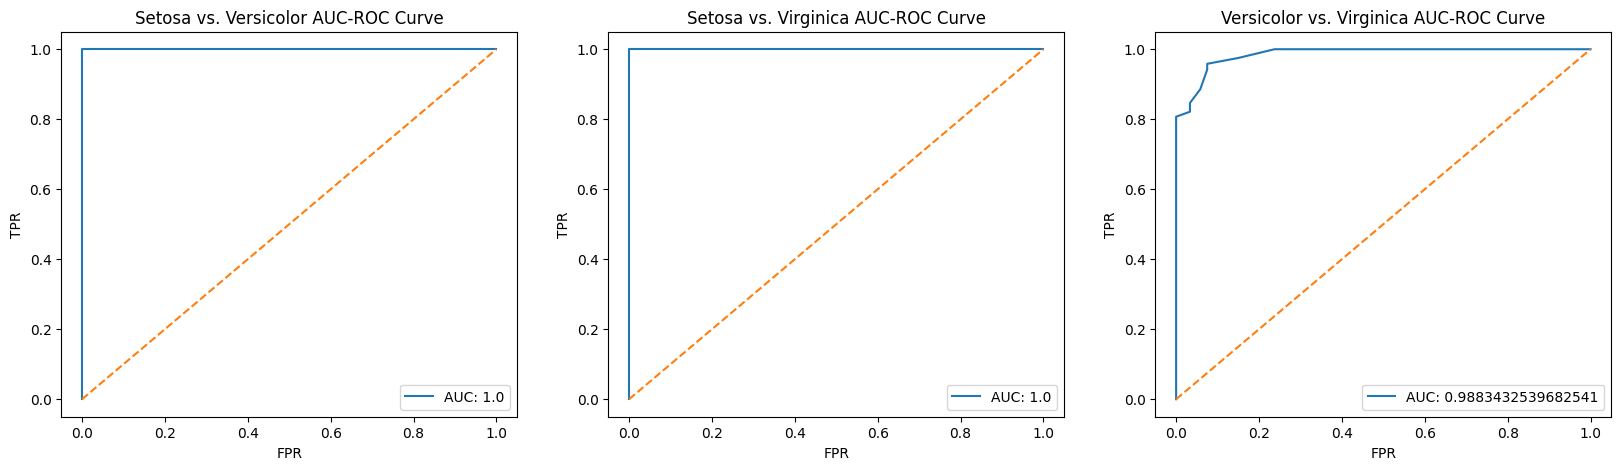

In [27]:
# cross validation cv is set to 10 and each dataset tested on each fold
figure, axis = plt.subplots(1, 3, figsize=(20, 5))
# Setosa Versicolor
tpr_sv, fpr_sv = cross_validation(s_versi_parts)
auc_sv = calculate_auc(tpr_sv, fpr_sv)
auc_sv = "AUC: " + str(auc_sv)
axis[0].set(xlabel='FPR', ylabel='TPR')
axis[0].set_title("Setosa vs. Versicolor AUC-ROC Curve")
axis[0].plot(fpr_sv, tpr_sv)
axis[0].plot([0,1], [0,1], linestyle='dashed')
axis[0].legend([auc_sv])
# Setosa Virginica
tpr_svir, fpr_svir = cross_validation(s_vir_parts)
auc_svir = calculate_auc(tpr_svir, fpr_svir)
auc_svir = "AUC: " + str(auc_svir)
axis[1].set(xlabel='FPR', ylabel='TPR')
axis[1].set_title("Setosa vs. Virginica AUC-ROC Curve")
axis[1].plot(fpr_svir, tpr_svir)
axis[1].plot([0,1], [0,1], linestyle='dashed')
axis[1].legend([auc_svir])
# Virginica Versicolor
tpr_vv, fpr_vv = cross_validation(vir_versi_parts)
auc_vv = calculate_auc(tpr_vv, fpr_vv)
auc_vv = "AUC: " + str(auc_vv)
axis[2].set(xlabel='FPR', ylabel='TPR')
axis[2].set_title("Versicolor vs. Virginica AUC-ROC Curve")
axis[2].plot(fpr_vv, tpr_vv)
axis[2].plot([0,1], [0,1], linestyle='dashed')
axis[2].legend([auc_vv])
plt.show()